# Detection of Chest X-Ray Abnormalities

This notebook was created and used as part of the EE581 course group project in the EEE department of Strathclyde University

## Import

Import modules and function used in this notebook

In [1]:
import numpy as np
import pandas as pd
import urllib.request
import tarfile
import os
import matplotlib.pyplot as plt
from PIL import Image
from skimage.transform import resize
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import progressbar
import time
import keras
import tensorflow as tf
from keras.utils import to_categorical

## Dataset import

***- Download the dataset:***
> taking only the 7 first folders of the full dataset
>> having more data was not useful for this project

In [28]:
# Function to download and extract images from a tar.gz file
def download_and_extract(url, filename):
    print(f"Downloading {filename}...")
    urllib.request.urlretrieve(url, filename)
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall()
    os.remove(filename)
    print(f"Extraction of {filename} complete.")

# URLs for the zip files
links = [#'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
         #'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
         #'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	       #'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
         'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
         #'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
]

# Download and extract images
for idx, link in enumerate(links):
    fn = f'images_{idx+1}.tar.gz'
    download_and_extract(link, fn)


Extraction of images_1.tar.gz complete.


If wanted more images can be add by using this links :
* images_8.tar.gz : 'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
* images_9.tar.gz : 'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
* images_10.tar.gz : 'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
* images_11.tar.gz : 'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
* images_12.tar.gz : 'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
* images_13.tar.gz : 'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'

Remove the content of the local folder if necessary

In [21]:
!rm -rf '/content/images'

***- Load csv file that countains the labels:***

In [17]:
df = pd.read_csv('Data_Entry_2017_v2020.csv')

## Create a class structure to save and analyse the dataset

List of possibles labels :

['No Finding', 'Mass', 'Pneumothorax', 'Fibrosis', 'Edema','Consolidation', 'Effusion', 'Hernia', 'Nodule','Infiltration', 'Emphysema', 'Pleural_Thickening','Pneumonia', 'Cardiomegaly', 'Atelectasis']

In [29]:
class ImageDataset:
  def __init__(self, data_folder, size=0, target_size=(224, 224)):
        self.data_folder = data_folder
        self.size = size
        self.nb_classes = 10
        self.class_names = []
        self.target_size = target_size
        self.X_train, self.X_test, self.X_val = [], [], []
        self.Y_train, self.Y_test, self.Y_val = [], [], []


  def load_and_preprocess_images(self, file_paths):
        images = []
        for file_path in file_paths:
            image_path = os.path.join(self.data_folder, file_path)
            # Check if the image file exists
            if os.path.exists(image_path):
                image = tf.io.read_file(image_path)
                image = tf.image.decode_png(image, channels=1)
                image = tf.image.resize(image, self.target_size)
                image = image / 255.0  # Normalize to [0, 1]
                images.append(np.asarray(image))

        return np.asarray(images)

  def load_data(self, df, high):
        # high is the upper limit of the number of data per class
        # Extract file paths and labels
        file_paths = df['Image Index'].values
        labels = (df['Finding Labels'].values)

        # keep only the extracted ones
        diseases = ['No Finding', 'Edema' ]
        X_temp = []
        Y_temp = []
        for n in range(len(file_paths)):
          if labels[n].find('|')==-1:
            if labels[n] in diseases:
              if os.path.exists(os.path.join(self.data_folder, file_paths[n])):
                X_temp.append(file_paths[n])
                Y_temp.append(labels[n])

        copy = Y_temp
        self.class_names= list(set(copy))
        print(self.class_names)
        self.nb_classes = len(self.class_names)

        # equalized the number of data of each type
        equalizer = np.random.randint(high*0.9, high, size=self.nb_classes)
        print(equalizer)
        X = []
        Y = []
        k=-1
        for l in Y_temp:
          idx = self.class_names.index(l)
          k+=1
          if equalizer[idx]>=0:
            equalizer[idx]-=1
            Y.append(idx)
            X.append(X_temp[k])
            if not np.any(equalizer):
              break

        # Split data
        # 80% of data for training, 20% for testing and validation
        train_files, temp_files, train_labels, temp_labels = train_test_split(X, Y, test_size=0.2)
        # 50% of the remaining data for testing, and 50% for validation
        test_files, val_files, test_labels, val_labels = train_test_split(temp_files, temp_labels, test_size=0.5)

        # Load and preprocess images
        self.X_train = tf.convert_to_tensor(self.load_and_preprocess_images(train_files))
        self.X_test = tf.convert_to_tensor(self.load_and_preprocess_images(test_files))
        self.X_val = tf.convert_to_tensor(self.load_and_preprocess_images(val_files))

        # Assign labels
        self.Y_train = tf.convert_to_tensor(train_labels)
        self.Y_test = tf.convert_to_tensor(test_labels)
        self.Y_val = tf.convert_to_tensor(val_labels)

        self.file_names_train = X


  def print_info(self):
        print(f"Training set size: {len(self.X_train)}")
        print(f"Testing set size: {len(self.X_test)}")
        print(f"Validation set size: {len(self.X_val)}")

  def display_samples(self, num_samples=3):
        # Display some samples from the training dataset
        for i in range(num_samples):
            sample_idx = np.random.randint(0, len(self.X_train))   # Select a random sample from the training set
            sample_image = self.X_train[sample_idx]
            sample_label = self.Y_train[sample_idx]
            sample_name = self.file_names_train[sample_idx]

            # Display the image and its label
            plt.figure(figsize=(6, 6))
            plt.imshow(sample_image[:, :, 0], cmap='gray')
            plt.title(f"Label: {sample_label}\nImage Name: {sample_name}")
            plt.axis('off')
            plt.show()

  def display_train_test(self):
    #display the data occurence of the training and testing sets
    from collections import Counter

    test = Counter(self.Y_test.numpy())
    train = Counter(self.Y_train.numpy())

    key_value_train = {};
    key_value_test = {};

    # get the number of data of each types in the two set
    for i in sorted(test.keys()):
      key_value_test[i] = test[i];
    for i in sorted(train.keys()):
      key_value_train[i] = train[i];

    p1 = plt.bar(key_value_train.keys(), key_value_train.values(), width=0.5);
    p2 = plt.bar( key_value_test.keys(), key_value_test.values(), width=0.5, bottom=list(key_value_train.values()) );

    plt.legend((p1[0], p2[0]), ('Training set', 'Test set'), loc='lower left')
    plt.xlabel('Labels')
    plt.ylabel('Occurrence')
    plt.title('Occurrence of training and testing sets')
    plt.show();

***- prepare the dataset***

['Edema', 'No Finding']
[458 488]
Training set size: 544
Testing set size: 68
Validation set size: 68


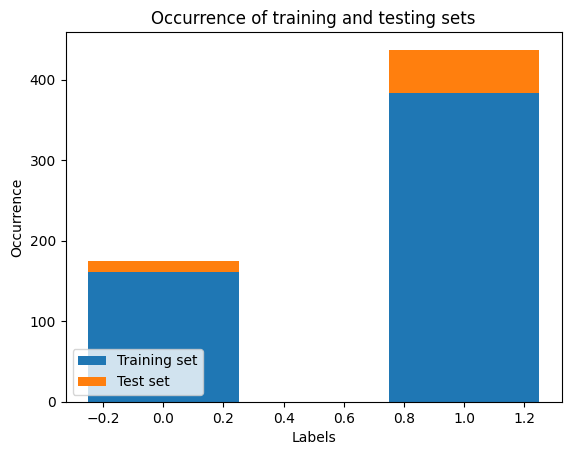

In [30]:
data_folder = '/content/images'
image_dataset = ImageDataset(data_folder, size=0)
# Load data using DataFrame from the CSV
image_dataset.load_data(df, 500)
image_dataset.print_info()
# Display some samples from the training dataset
# image_dataset.display_samples(num_samples=1)
image_dataset.display_train_test()

## Models

Three models are proposed, a Fully connected (Dense Neural network), an AlexNet and VGG19 Architecture.

### Fully connected

Creation of a fully connected model with 3 layers NN architecture :

In [6]:
hidden1 = 10^4
hidden2 = 10^3
hidden3 = 10^2


model = keras.models.Sequential([
    keras.layers.Input((224, 224, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(hidden1, activation='relu'),
    keras.layers.Dense(hidden2, activation='relu'),
    keras.layers.Dense(hidden3, activation='relu'),
    keras.layers.Dense(image_dataset.nb_classes, activation='softmax')
])

model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 14)                702478    
                                                                 
 dense_1 (Dense)             (None, 9)                 135       
                                                                 
 dense_2 (Dense)             (None, 8)                 80        
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 702711 (2.68 MB)
Trainable params: 702711 (2.68 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### AlexNet

Create a model with an AlexNet Architecture

In [7]:
act = 'relu'
nb_class = image_dataset.nb_classes

model = keras.models.Sequential()
#Input
model.add( keras.layers.Input((224,224,1)) )

#AlexNet
model.add( keras.layers.Conv2D(96, kernel_size=(11,11), strides= 4, activation=act))
model.add( keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2),))

model.add( keras.layers.Conv2D(256, kernel_size=(5,5), strides= 1, activation=act))
model.add( keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2)))

model.add( keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, activation=act))
model.add( keras.layers.Conv2D(384, kernel_size=(3,3), strides= 1, activation=act))
model.add( keras.layers.Conv2D(256, kernel_size=(3,3), strides= 1, activation=act))
model.add( keras.layers.MaxPooling2D(pool_size=(3,3), strides= (2,2)))

model.add( keras.layers.Flatten())
model.add( keras.layers.Dense(4096, activation= act))
model.add( keras.layers.Dropout(0.5))
model.add( keras.layers.Dense(4096, activation= act))
model.add( keras.layers.Dropout(0.5))
model.add( keras.layers.Dense(1000, activation= act))

#Output
model.add( keras.layers.Dense(image_dataset.nb_classes, activation= 'softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        11712     
                                                                 
 max_pooling2d (MaxPooling2  (None, 26, 26, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 384)         885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 384)        

### VGG19

Create a model with a VGG19 architecture

In [ ]:
model = keras.models.Sequential()

# Block 1
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2)))

# Fully Connected Layers
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dense(4096, activation='relu'))
model.add(keras.layers.Dense(image_dataset.nb_classes, activation='softmax'))

model.summary()

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Training and testing

### Training

Notebook has to be configured to use GPU to a better performance.

If on Google Colab go to: Execution -> modify the execution time and select GPU

The model of the GPU can be checked by running the code below:

In [ ]:
tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9385972717543768954
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14626652160
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 15208818584000238885
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
 xla_global_id: 416903419]

***- Train the model :***

In [8]:
batch_size  = 128
epochs      =  40
t0=time.time()
h = model.fit(image_dataset.X_train, image_dataset.Y_train,
                      batch_size      = batch_size,
                      epochs          = epochs,
                      verbose         = True,
                      validation_data = (image_dataset.X_test, image_dataset.Y_test))
tn = time.time()-t0;

Epoch 1/40
5/5 [==============================] - 13s 717ms/step - loss: 0.7407 - accuracy: 0.6080 - val_loss: 0.5543 - val_accuracy: 0.7538
Epoch 2/40
5/5 [==============================] - 0s 64ms/step - loss: 0.6879 - accuracy: 0.5832 - val_loss: 0.6879 - val_accuracy: 0.7538
Epoch 3/40
5/5 [==============================] - 0s 64ms/step - loss: 0.6850 - accuracy: 0.7075 - val_loss: 0.6723 - val_accuracy: 0.7538
Epoch 4/40
5/5 [==============================] - 0s 64ms/step - loss: 0.6696 - accuracy: 0.7075 - val_loss: 0.6299 - val_accuracy: 0.7538
Epoch 5/40
5/5 [==============================] - 0s 63ms/step - loss: 0.6270 - accuracy: 0.7075 - val_loss: 0.5586 - val_accuracy: 0.7538
Epoch 6/40
5/5 [==============================] - 0s 63ms/step - loss: 0.6078 - accuracy: 0.7075 - val_loss: 0.5692 - val_accuracy: 0.7538
Epoch 7/40
5/5 [==============================] - 0s 66ms/step - loss: 0.6050 - accuracy: 0.7075 - val_loss: 0.5751 - val_accuracy: 0.7538
Epoch 8/40
5/5 [=========

***- Test the model :***

In [9]:
score = model.evaluate(image_dataset.X_test, image_dataset.Y_test, verbose=True)

print(f'Test loss     : {score[0]:4.4f}')
print(f'Test accuracy : {score[1]:4.4f}')

err = 100*(1-np.array(score))

3/3 [==============================] - 1s 150ms/step - loss: 0.5644 - accuracy: 0.7538
Test loss     : 0.5644
Test accuracy : 0.7538


***- Draw train history (accuracy, loss function) by epoch :***

Test err:  24.62 %  time: 0.71 min


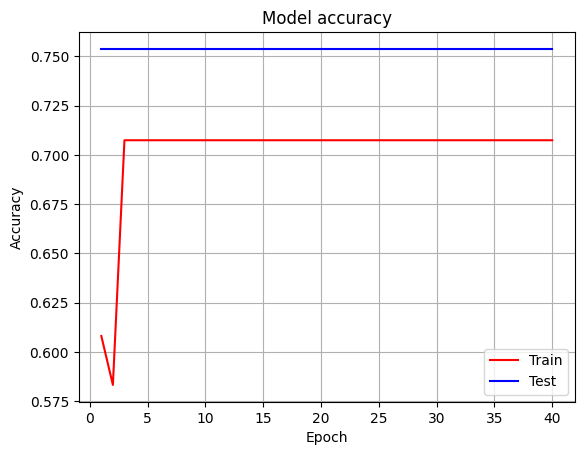

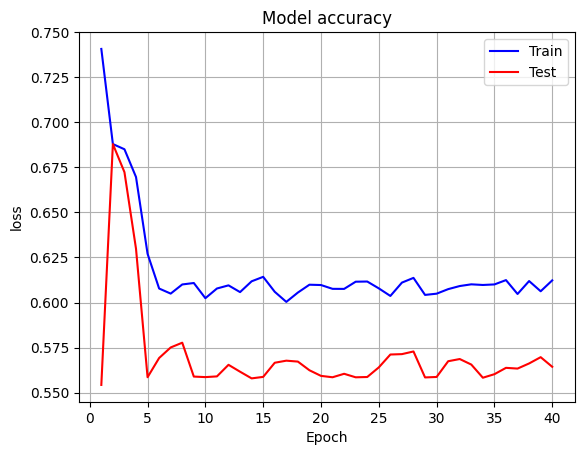

In [10]:
print('Test err:  %4.2f %%  time: %4.2f min'% (err[1],tn/60))

plt.plot(list(range(1,len(h.history['accuracy'])+1)),h.history['accuracy'],'r')
plt.plot(list(range(1,len(h.history['val_accuracy'])+1)),h.history['val_accuracy'],'b')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(('Train', 'Test'), loc='lower right')
plt.grid()
plt.show()

plt.plot(list(range(1,len(h.history['loss'])+1)),h.history['loss'],'b')
plt.plot(list(range(1,len(h.history['val_loss'])+1)),h.history['val_loss'],'r')
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(('Train', 'Test'), loc='upper right')
plt.grid()
plt.show()

### predict

***- Perform a prediction :***

In [11]:
y_sigmoid = model.predict(image_dataset.X_val, verbose=True)
y_pred    = np.argmax(y_sigmoid, axis=-1)

errors=[ i for i in range(len(image_dataset.X_val)) if y_pred[i]!=image_dataset.Y_val[i] ]

3/3 [==============================] - 1s 207ms/step


## Performance measure

### accuracy mesure

***accuracy metrics function***

The function is fed by the true labels and the prediction to plot the confusion matrix and compute the accuracy, Kappa score, Precisio, recall and F1-score.

In [12]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, ConfusionMatrixDisplay, precision_recall_fscore_support
import pandas as pd

def accuracy_metrics(true, predicted, class_names):
  # get the class names
  y_true = [class_names[i] for i in true]
  y_pred = [class_names[i] for i in predicted]
  #compute and plot the confusion matrix
  conf_mx = confusion_matrix(y_true, y_pred, labels=class_names, normalize='true')
  disp = ConfusionMatrixDisplay(conf_mx, display_labels=class_names)
  disp.plot(cmap='Blues')

  # Compute Accuracy and Kappa coefficient
  accuracy = np.trace(conf_mx) / float(np.sum(conf_mx))
  print("Overall Accuracy : {:0.4f}  (misclass ={:0.4f})".format(accuracy, 1-accuracy))
  kappa = cohen_kappa_score(true, predicted)
  print("Cohen's Coefficient : {:0.4f}".format(kappa))
  d={}
  # compute recall and precision for each class
  d['precison'], d['recall'], d['f1'], _ = precision_recall_fscore_support(y_true, y_pred, labels=class_names)
  df = pd.DataFrame(data=d, index=class_names)
  display(df)

Overall Accuracy : 0.5000  (misclass =0.5000)
Cohen's Coefficient : 0.0000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precison,recall,f1
No Finding,0.651515,1.0,0.788991
Atelectasis,0.000000,0.0,0.000000


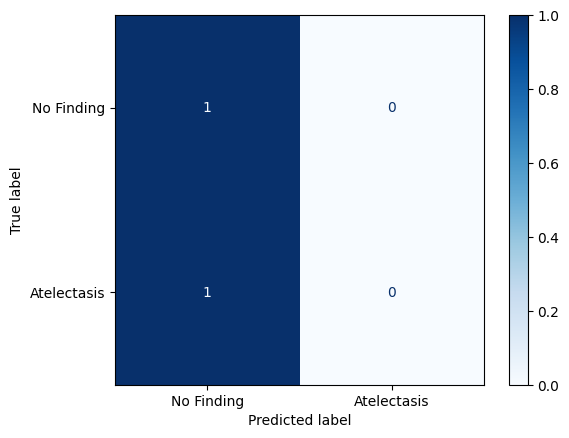

In [13]:
accuracy_metrics(image_dataset.Y_val, y_pred, image_dataset.class_names)

## Archives Edema


Overall Accuracy : 0.7913  (misclass =0.2087)
Cohen's Coefficient : 0.5827


,precison,recall,f1
Edema,0.777778,0.777778,0.777778
No Finding,0.804878,0.804878,0.804878


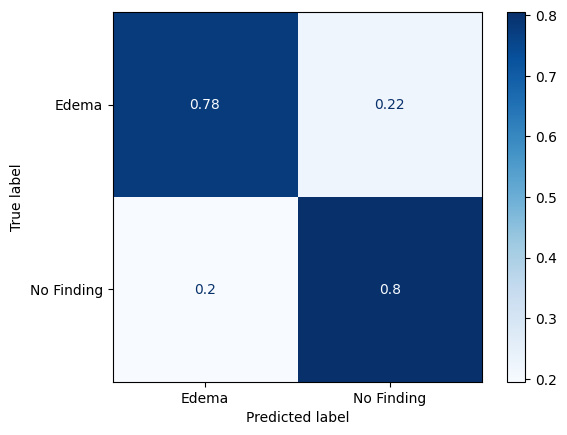

In [ ]:
accuracy_metrics(image_dataset.Y_val, y_pred, image_dataset.class_names) #dense 40 epochs

Overall Accuracy : 0.8910  (misclass =0.1090)
Cohen's Coefficient : 0.7571


,precison,recall,f1
No Finding,0.952381,0.851064,0.898876
Edema,0.794118,0.931034,0.857143


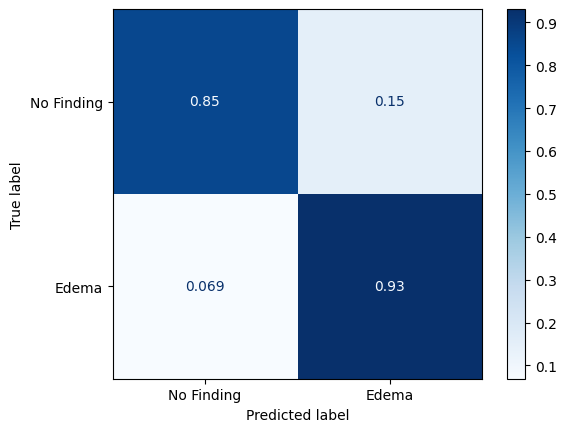

In [ ]:
accuracy_metrics(image_dataset.Y_val, y_pred, image_dataset.class_names) #20 epochs less data Edema